# Part 1 -Project 

In [412]:
# %tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.7.0'

In [413]:
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [414]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from PIL import Image
from numpy import asarray

from sklearn.datasets import load_files

In [415]:
# Loading the images file

data = np.load('Data/images.npy', allow_pickle=True)

In [416]:
data.shape

(409, 2)

The file contains 409 images and labels. Let's view few images and their labels.

In [417]:
data[100][0]

array([[[200, 185, 118],
        [206, 191, 124],
        [203, 188, 121],
        ...,
        [204, 146,  46],
        [212, 154,  54],
        [205, 147,  47]],

       [[203, 188, 121],
        [206, 191, 124],
        [200, 185, 118],
        ...,
        [203, 145,  45],
        [208, 150,  50],
        [214, 156,  56]],

       [[199, 184, 117],
        [203, 188, 121],
        [202, 187, 120],
        ...,
        [203, 145,  45],
        [193, 135,  35],
        [202, 144,  44]],

       ...,

       [[ 63,   1,   2],
        [ 66,   2,   3],
        [ 66,   2,   2],
        ...,
        [  3,   0,   0],
        [  4,   0,   0],
        [  4,   0,   0]],

       [[ 66,   2,   3],
        [ 66,   2,   3],
        [ 67,   3,   3],
        ...,
        [  1,   0,   0],
        [  2,   1,   0],
        [  3,   2,   0]],

       [[ 64,   0,   1],
        [ 64,   0,   0],
        [ 66,   0,   1],
        ...,
        [  1,   1,   0],
        [  2,   2,   0],
        [  3,   3,   1]]

In [418]:
data[23][1]

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.22545454545454546, 'y': 0.37142857142857144},
   {'x': 0.49454545454545457, 'y': 0.7971428571428572}],
  'imageWidth': 275,
  'imageHeight': 350},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.4218181818181818, 'y': 0.5228571428571429},
   {'x': 0.7527272727272727, 'y': 0.8628571428571429}],
  'imageWidth': 275,
  'imageHeight': 350}]

In [419]:
cv2.imshow('img',data[23][0])
# waits for user to press any key
# (this is necessary to avoid Python kernel form crashing)
cv2.waitKey(0)
  
# closing all open windows
cv2.destroyAllWindows()

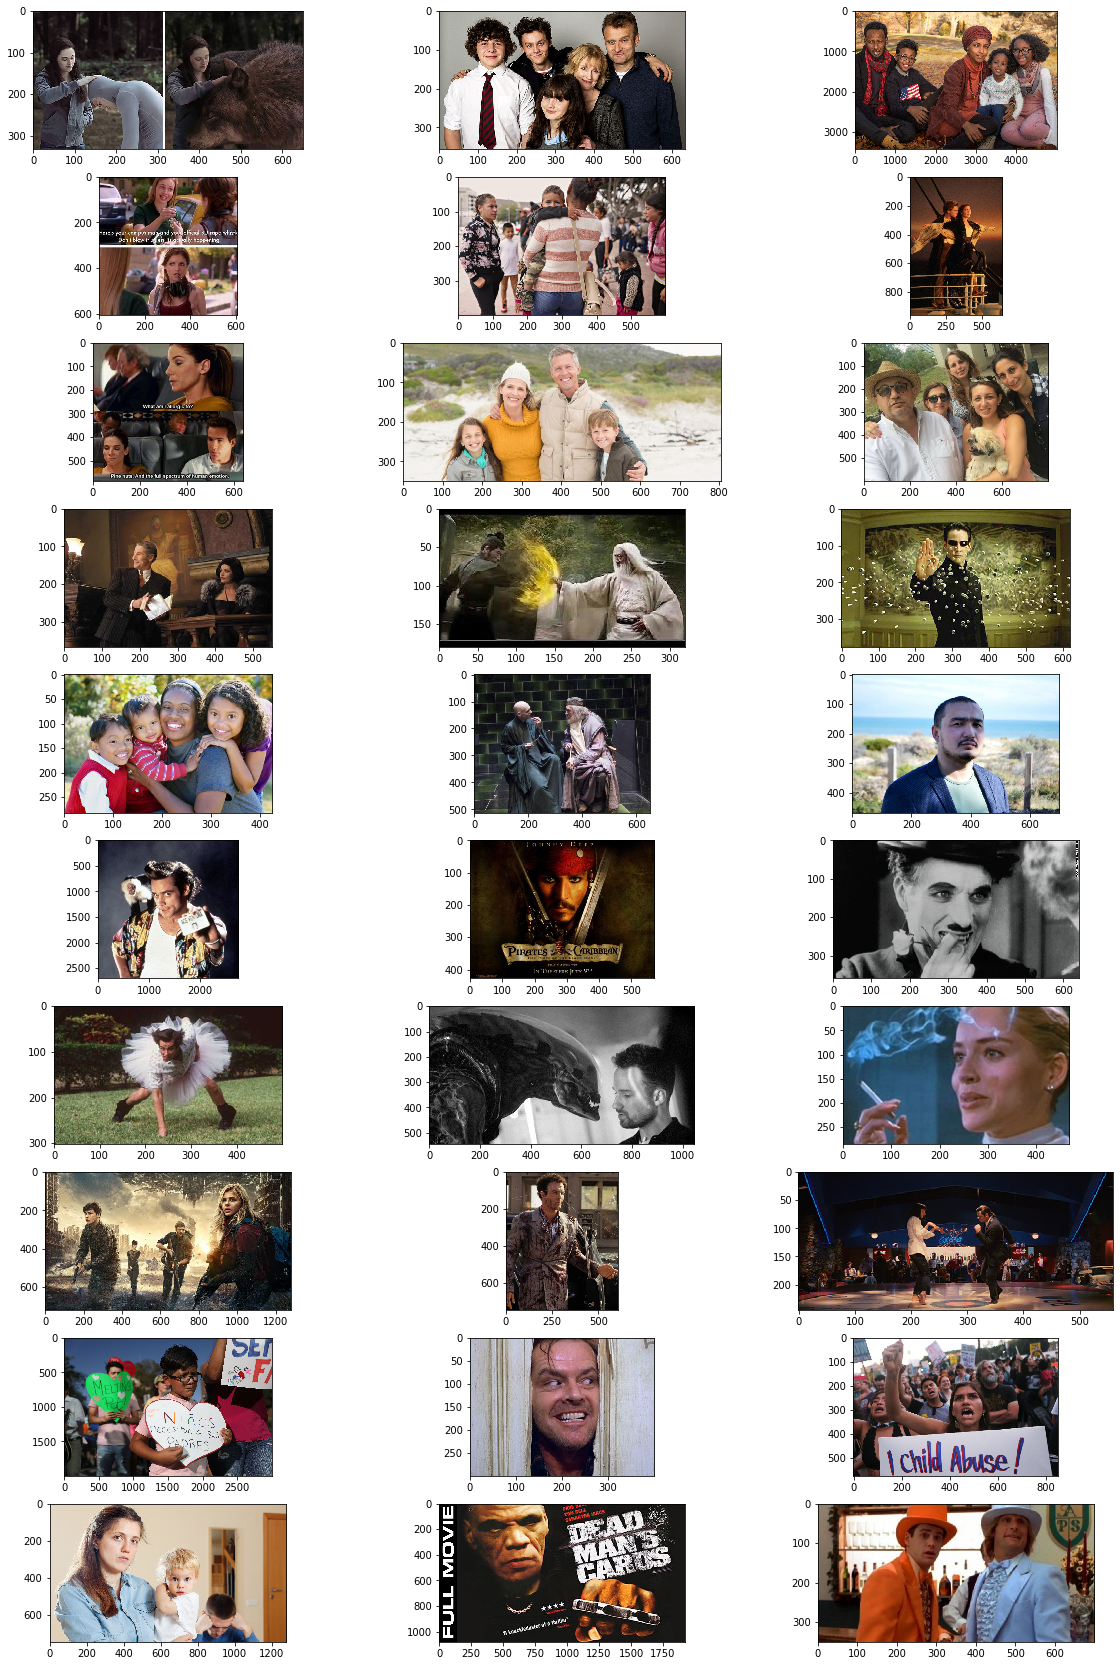

In [420]:
fi,ax = plt.subplots(10,3,figsize=(20,30))
row = 0
col = 0
index = 0
for i in range(30):
  ax[row][col].imshow(data[index][0], interpolation='nearest')
  index = index + 6
  col = col + 1
  if col > 2:
    row = row + 1
    col = 0
plt.show()

**Image Pre-Processing**

In [421]:
from tensorflow.keras.applications.mobilenet import preprocess_input

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

IMAGE_SIZE = 224

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]),IMAGE_HEIGHT, IMAGE_WIDTH, 3))

for index in range(data.shape[0]):
  img = data[index][0]
  img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
  # assign all pixels in the first 3 channels only to the image, i.e., discard the alpha channel
  try:
    img = img[:,:,:3]
  except:
    print(f"Exception {index} Grayscale image with shape {img.shape}")
    # convert the grayscale image to color so that the number of channels are standardized to 3
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    continue
  X[index] = preprocess_input(np.array(img, dtype=np.float32))
  # Loop through the face co-ordinates and create mask out of it.
  for i in data[index][1]:
    x1 = int(i['points'][0]['x'] * IMAGE_WIDTH)
    x2 = int(i['points'][1]['x'] * IMAGE_WIDTH)
    y1 = int(i['points'][0]['y'] * IMAGE_HEIGHT)
    y2 = int(i['points'][1]['y'] * IMAGE_HEIGHT)
    # set all pixels within the mask co-ordinates to 1.
    masks[index][y1:y2, x1:x2] = 1
print(f"### Shape of X is '{X.shape}' and the shape of mask is '{masks.shape}' ")

Exception 272 Grayscale image with shape (224, 224)
### Shape of X is '(409, 224, 224, 3)' and the shape of mask is '(409, 224, 224)' 


In [422]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, masks, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2)

print(f"Shape of X_train is '{X_train.shape}' and the shape of y_train is '{y_train.shape}'")
print(f"Shape of X_val is '{X_val.shape}' and the shape of y_val is '{y_val.shape}'")
print(f"Shape of X_test is '{X_test.shape}' and the shape of y_test is '{y_test.shape}'")

Shape of X_train is '(327, 224, 224, 3)' and the shape of y_train is '(327, 224, 224)'
Shape of X_val is '(65, 224, 224, 3)' and the shape of y_val is '(65, 224, 224)'
Shape of X_test is '(17, 224, 224, 3)' and the shape of y_test is '(17, 224, 224)'


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


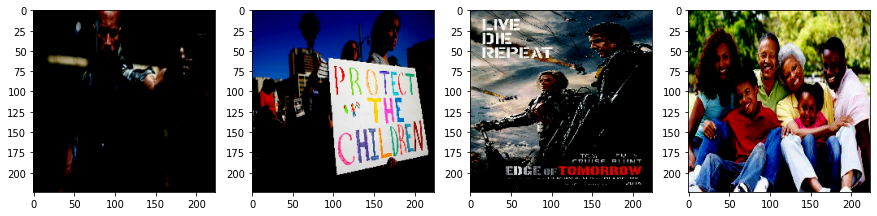

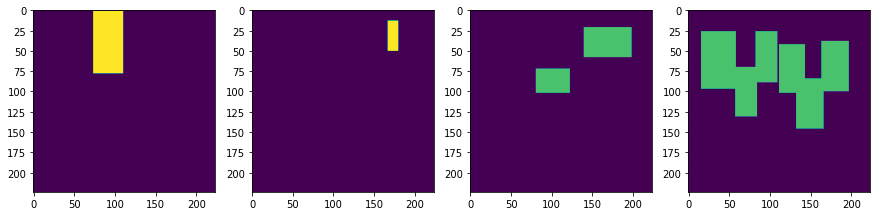

In [23]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(X_train[0])

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(X_train[10])
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(X_train[20])
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(X_train[30])
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(y_train[0])

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(y_train[10])
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(y_train[20])
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(y_train[30])
imgplot.set_clim(0.0, 1.4)

**Creating a Mask Detection Model using U-net with MobileNet Transfer Learning Model**

In [423]:
IMAGE_SIZE = 224
EPOCHS = 30
BATCH = 8
LR = 1e-4

In [424]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [425]:
model = model()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 16  432         ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 16  64          ['Conv1[0][0]']                  
                                )                                                           

**Designing Dice Coefficient and Loss function**

In [426]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

**Compliling the Model**

In [427]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [29]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

In [30]:
train_steps = len(X_train)//BATCH
valid_steps = len(X_val)//BATCH

if len(X_train) % BATCH != 0:
    train_steps += 1
if len(X_val) % BATCH != 0:
    valid_steps += 1

model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/30
41/41 [==============================] - 77s 2s/step - loss: 0.7340 - dice_coef: 0.2659 - recall: 0.8873 - precision: 0.1824 - val_loss: 0.7599 - val_dice_coef: 0.2248 - val_recall: 1.0000 - val_precision: 0.1307 - lr: 1.0000e-04
Epoch 2/30
41/41 [==============================] - 63s 2s/step - loss: 0.6419 - dice_coef: 0.3583 - recall: 0.9332 - precision: 0.3236 - val_loss: 0.7260 - val_dice_coef: 0.2560 - val_recall: 0.9995 - val_precision: 0.1492 - lr: 1.0000e-04
Epoch 3/30
41/41 [==============================] - 67s 2s/step - loss: 0.6114 - dice_coef: 0.3887 - recall: 0.9459 - precision: 0.3712 - val_loss: 0.6714 - val_dice_coef: 0.3075 - val_recall: 0.9921 - val_precision: 0.2372 - lr: 1.0000e-04
Epoch 4/30
41/41 [==============================] - 75s 2s/step - loss: 0.5916 - dice_coef: 0.4084 - recall: 0.9593 - precision: 0.3807 - val_loss: 0.6448 - val_dice_coef: 0.3342 - val_recall: 0.9870 - val_precision: 0.2790 - lr: 1.0000e-04
Epoch 5/30
41/41 [==================

In [31]:
model.save('CVUnet.h5')

In [428]:
#load the model

new_model= tensorflow.keras.models.load_model('CVUnet.h5',custom_objects={'dice_loss': dice_loss,'dice_coef': dice_coef})



In [429]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 16  432         ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 16  64          ['Conv1[0][0]']                  
                                )                                                             

In [430]:
test_steps = (len(X_test)//BATCH)
if len(X_test) % BATCH != 0:
    test_steps += 1

new_model.evaluate(X_test, y_test, steps=test_steps)

3/3 [==============================] - 5s 303ms/step - loss: 0.4600 - dice_coef: 0.5342 - recall: 0.7583 - precision: 0.8071


[0.46004775166511536,
 0.5342147946357727,
 0.7583245038986206,
 0.807067334651947]

**Predicting an image that was not used for training and testing the model**

In [431]:
filename ='Data/Part+1Test+Data+-+Prediction+Image.jpeg'
unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

In [432]:
feat_scaled

array([[[ 0.5686275 ,  0.4666667 ,  0.45098042],
        [ 0.56078434,  0.45882356,  0.4431373 ],
        [ 0.5764706 ,  0.47450984,  0.45882356],
        ...,
        [-0.17647058, -0.5058824 , -0.73333335],
        [-0.27058822, -0.49019605, -0.75686276],
        [-0.27843136, -0.47450978, -0.7411765 ]],

       [[ 0.6       ,  0.49803925,  0.48235297],
        [ 0.6       ,  0.4901961 ,  0.48235297],
        [ 0.6313726 ,  0.5294118 ,  0.5137255 ],
        ...,
        [-0.20784312, -0.52156866, -0.7490196 ],
        [-0.16862744, -0.40392154, -0.6627451 ],
        [-0.19215685, -0.41176468, -0.6784314 ]],

       [[ 0.54509807,  0.45098042,  0.41960788],
        [ 0.47450984,  0.3803922 ,  0.34901965],
        [ 0.5372549 ,  0.4431373 ,  0.4039216 ],
        ...,
        [-0.14509803, -0.42745095, -0.6627451 ],
        [-0.3098039 , -0.5686275 , -0.827451  ],
        [-0.34117645, -0.5921569 , -0.8509804 ]],

       ...,

       [[-1.        , -1.        , -1.        ],
        [-1

In [433]:
y_pred = new_model.predict(np.array([feat_scaled]))
y_pred

array([[[[0.17036197],
         [0.15527216],
         [0.10860014],
         ...,
         [0.10471413],
         [0.11665457],
         [0.14584196]],

        [[0.1503942 ],
         [0.14134693],
         [0.10738048],
         ...,
         [0.10415772],
         [0.12254664],
         [0.1267032 ]],

        [[0.10826859],
         [0.10619867],
         [0.10784283],
         ...,
         [0.10895398],
         [0.10891101],
         [0.11973789]],

        ...,

        [[0.10260427],
         [0.10458368],
         [0.11108592],
         ...,
         [0.10997057],
         [0.10522434],
         [0.11393836]],

        [[0.10231951],
         [0.10114568],
         [0.10504085],
         ...,
         [0.10601571],
         [0.11285844],
         [0.12970859]],

        [[0.13998067],
         [0.12768617],
         [0.12298313],
         ...,
         [0.12232521],
         [0.11775053],
         [0.15591204]]]], dtype=float32)

In [434]:
pred_mask = cv2.resize((1.0*(y_pred[0] > .5)), (IMAGE_WIDTH,IMAGE_HEIGHT))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


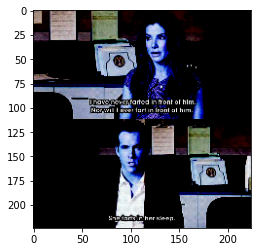

In [435]:
plt.imshow(feat_scaled)

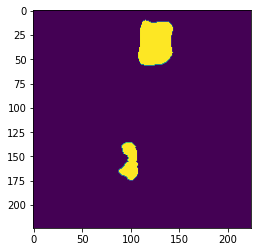

In [436]:
plt.imshow(pred_mask)

**The model was able to detect two faces in the image correctly.**

# Part 2

In [261]:
from tqdm.notebook import trange, tqdm
from IPython.display import Image, display, Markdown, clear_output
from zipfile import ZipFile as z
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from mpl_toolkits.axes_grid1 import ImageGrid
import glob
import os


In [262]:
Project_path = 'C:/Users/AI_SG/Documents/Upendran/Course/python/Projects/Computer Vision/PROJECT 2/'

#### Extract the zip file 
- Extract Aligned Face Dataset from Pinterest.zip

In [264]:
from zipfile import ZipFile

# specifying the zip file name
file_name = Project_path +"Data/Aligned Face Dataset from Pinterest - CV project 2.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as z:
   # extracting all the files
    print('Extracting all the files now...')
    z.extractall()
    print('Done!')

Extracting all the files now...


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\AI_SG\\Documents\\Upendran\\Course\\python\\Projects\\Computer Vision\\PROJECT 2\\PINS\\pins_Natalie Portman \\Natalie Portman 0.jpg'

### Function to load images
- Define a function to load the images from the extracted folder and map each image with person id 


In [313]:
TRAIN_FOLDER = 'PINS'
from glob import glob
images = []
classes=[]
missing=0
for class_folder_name in os.listdir(TRAIN_FOLDER):
    class_folder_path = os.path.join(TRAIN_FOLDER, class_folder_name)
    class_label = class_folder_name
    
    for image_path in glob(os.path.join(class_folder_path, "*.jpg")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image_bgr is None: # if the file contain any missing value ignore it
          missing += 1
          continue
        images.append(image_bgr)
        
        classes.append(class_label)

In [314]:
# resize image
def resize_images(img):

  img = np.array(img).astype(np.uint8)
  #print(img.dtype)
  res = cv2.resize(img,(224,224), interpolation = cv2.INTER_CUBIC)
  return res

#save resized images into images.
images = [resize_images(img) for img in images]

In [315]:
#see number of images in each label
images = np.array(images)
classes = np.array(classes)
print("images shape: ", images.shape)
print("classes shape: ", classes.shape)

images shape:  (4382, 224, 224, 3)
classes shape:  (4382,)


In [316]:
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('PINS')

### Define function to load image
- Define a function to load image from the metadata

In [317]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

#### Load a sample image 
- Load one image using the function "load_image"

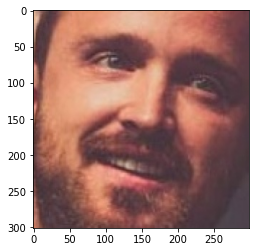

In [352]:
# Load an image
# for example, loading the image with index 1
plt.imshow(load_image(metadata[0].image_path()))


### VGG Face model


In [319]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

#### Load the model 
- Load the model defined above
- Then load the given weight file named "vgg_face_weights.h5"

In [320]:
from tensorflow.keras.models import model_from_json
weights_file = 'Data/vgg_face_weights.h5'
model = vgg_face()
model.load_weights(weights_file)

### Get vgg_face_descriptor

In [321]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

### Generate embeddings for each image in the dataset
- Given below is an example to load the first image in the metadata and get its embedding vector from the pre-trained model. 

In [322]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


#### Generate embeddings for all images  [ Score: 3 points ]
- Write code to iterate through metadata and create embeddings for each image using `vgg_face_descriptor.predict()` and store in a list with name `embeddings`

- If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 2622-zeroes as the final embedding from the model is of length 2622.

In [329]:
embeddings = np.zeros((metadata.shape[0], 2622))
for i, m in enumerate(metadata):
    img_path = metadata[i].image_path()
    img = load_image(img_path)
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    embeddings[i]=embedding_vector

In [330]:
len(embeddings)

4382

In [331]:
embeddings 

array([[ 0.03170304, -0.0150513 , -0.01243402, ...,  0.00043139,
         0.00219081, -0.00908097],
       [ 0.03497701, -0.00105061, -0.01248934, ..., -0.0105309 ,
         0.00179322,  0.02439155],
       [ 0.02801891, -0.00112631, -0.0126575 , ..., -0.00904751,
        -0.00578403,  0.0212583 ],
       ...,
       [ 0.00633465,  0.00460462, -0.00857739, ..., -0.00243808,
         0.00556754,  0.00227435],
       [ 0.01565452,  0.00558202, -0.00874991, ..., -0.00294676,
         0.00372011, -0.00933463],
       [ 0.03565785,  0.01043394, -0.00349362, ..., -0.0022366 ,
         0.00233227,  0.0023782 ]])

### Since all the embedding takes huge time, we can store it local disk and use it wherever necessary 

In [332]:
# At first, we have to import the 'Shelve' module.
import shelve
  
# In this step, we create a shelf file.
shfile = shelve.open("shelf_file")
  
# we create a data object which in this case is a book_list.
embed_list = embeddings
  
# we are assigning a dictionary key to the list 
# which we will want to retrieve
shfile['embed_list']= embed_list
  
# now, we simply close the shelf file.
shfile.close()

In [333]:
# At first, we import the 'Shelve' module.
import shelve
  
# In this step, we create a shelf file.
var = shelve.open("shelf_file")
  
# Now, this 'var' variable points to all the 
# data objects in the file 'shelf_file'.
# print(var['embed_list'])
new_embed = var['embed_list']
# now, we simply close the file 'shelf_file'.
var.close()

In [334]:
len(new_embed)

4382

In [335]:
new_embed

array([[ 0.03170304, -0.0150513 , -0.01243402, ...,  0.00043139,
         0.00219081, -0.00908097],
       [ 0.03497701, -0.00105061, -0.01248934, ..., -0.0105309 ,
         0.00179322,  0.02439155],
       [ 0.02801891, -0.00112631, -0.0126575 , ..., -0.00904751,
        -0.00578403,  0.0212583 ],
       ...,
       [ 0.00633465,  0.00460462, -0.00857739, ..., -0.00243808,
         0.00556754,  0.00227435],
       [ 0.01565452,  0.00558202, -0.00874991, ..., -0.00294676,
         0.00372011, -0.00933463],
       [ 0.03565785,  0.01043394, -0.00349362, ..., -0.0022366 ,
         0.00233227,  0.0023782 ]])

### Function to calculate distance between given 2 pairs of images.

- Consider distance metric as "Squared L2 distance"
- Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [336]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

#### Plot images and get distance between the pairs given below
- 2, 3 and 2, 180
- 30, 31 and 30, 100
- 70, 72 and 70, 115

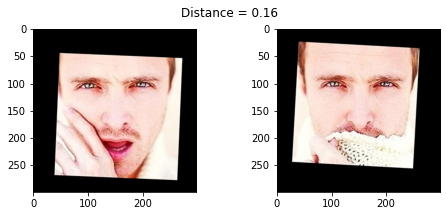

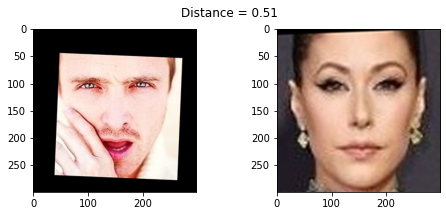

In [337]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 180)

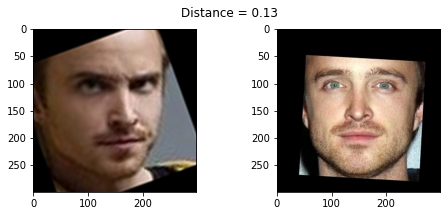

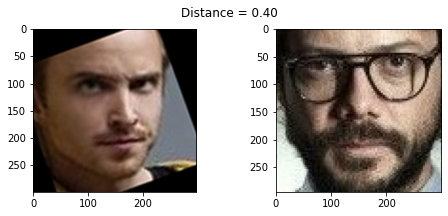

In [338]:
show_pair(30, 31)
show_pair(30, 100)

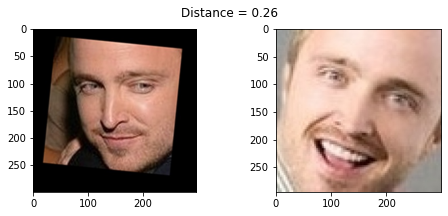

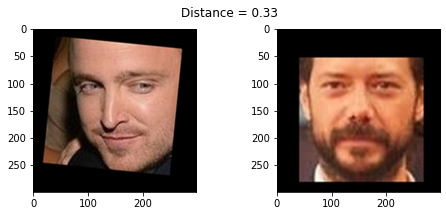

In [339]:
show_pair(70, 72)
show_pair(70, 115)

#### Create train and test sets 
- Create X_train, X_test and y_train, y_test
- Use train_idx to seperate out training features and labels
- Use test_idx to seperate out testing features and labels

In [359]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]
# another half as test examples of 10 identities
X_test = embeddings[test_idx]

targets = np.array([m.name for m in metadata])
y_train = targets[train_idx]
y_test = targets[test_idx]

#### Encode the Labels  
- Encode the targets
- Use LabelEncoder

In [360]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# Numerical encoding of identities
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

#### Standardize the feature values 
- Scale the features using StandardScaler

In [361]:
# Standarize features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### Reduce dimensions using PCA 
- Reduce feature dimensions using Principal Component Analysis
- Set the parameter n_components=128

In [362]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128, svd_solver='randomized', whiten=True)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [363]:
X_train.shape,X_test.shape

((3895, 128), (487, 128))

In [197]:
y_train.shape,y_test.shape

((7790,), (974,))

#### Build a Classifier 
- Use SVM Classifier to predict the person in the given image
- Fit the classifier and print the score

In [364]:
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve, GridSearchCV

param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
svc = SVC()
clf = GridSearchCV(svc, param_grid, verbose=10, n_jobs=-1)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}],
             verbose=10)

In [366]:
def getAccuracy(testSet, predictions):
	correct = 0
	for x in range(len(testSet)):
		if testSet[x]== predictions[x]:
			correct += 1
	return (correct/float(len(testSet))) * 100.0

In [365]:
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.989987163029525
0.9856262833675564


In [367]:
y_pred = clf.predict(X_test)

In [391]:
svm_acc=getAccuracy(y_test , y_pred) 
svm_acc

98.56262833675564

#### Test results 
- Take 10th image from test set and plot the image
- Report to which person(folder name in dataset) the image belongs to

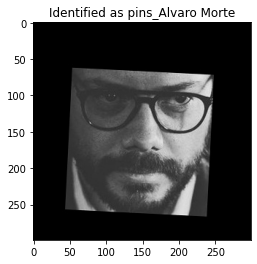

In [369]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 10

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = clf.predict([X_test[example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

In [406]:
model_performance = pd.DataFrame(columns=['Model', 'Accuracy','Label', 'Predicted Person'])

**Prediction of Test Image 1**

In [399]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = 'Data/Benedict+Cumberbatch9.jpg'
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
# print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

prd_embedding_vector1 = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
# print(prd_embedding_vector1.shape)
# print(prd_embedding_vector1)

In [400]:
X_pred = prd_embedding_vector1
X_pred = X_pred.reshape(1,-1)

In [401]:
X_pred = sc.transform(X_pred)

In [402]:
X_pred = pca.transform(X_pred)

In [403]:
pred_svm = clf.predict(X_pred)

print(f"The predicted label is:'{pred_svm}'")

The predicted label is:'[5]'


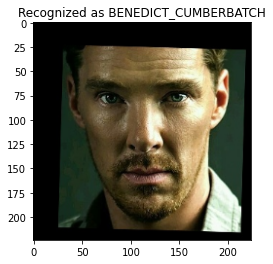

In [404]:
example_identity = enc.inverse_transform(np.ravel(pred_svm))[0]

plt.imshow(img)
plt.title(f'Recognized as {example_identity}');

In [407]:
model_performance = model_performance.append({'Model':'SVM',
                                              'Accuracy': svm_acc,
                                              'Label': pred_svm,
                                              'Predicted Person': example_identity                                      
                                              }, ignore_index=True)

model_performance

,Model,Accuracy,Label,Predicted Person
0,SVM,98.562628,[5],BENEDICT_CUMBERBATCH


**Prediction of Test Image 2**

The predicted label is:'[19]'


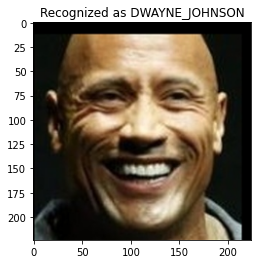

In [441]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = 'Data/Dwayne+Johnson4.jpg'
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
# print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

prd_embedding_vector1 = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
# print(prd_embedding_vector1.shape)
# print(prd_embedding_vector1)


X_pred = prd_embedding_vector1
X_pred = X_pred.reshape(1,-1)
#StandardScaler 
X_pred = sc.transform(X_pred)
#Passing through PCA
X_pred = pca.transform(X_pred)

# Predict using SVM model
pred_svm = clf.predict(X_pred)
print(f"The predicted label is:'{pred_svm}'")

#show the predicted label and image
example_identity = enc.inverse_transform(np.ravel(pred_svm))[0]

plt.imshow(img)
plt.title(f'Recognized as {example_identity}');

In [410]:
model_performance = model_performance.append({'Model':'SVM',
                                              'Accuracy': svm_acc,
                                              'Label': pred_svm,
                                              'Predicted Person': example_identity                                      
                                              }, ignore_index=True)

model_performance

,Model,Accuracy,Label,Predicted Person
0,SVM,98.562628,[5],BENEDICT_CUMBERBATCH
1,SVM,98.562628,[19],DWAYNE_JOHNSON
